In [ ]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import math


: 

In [2]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


##### Grover Operator Setup

In [3]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ Convert a given pattern to an oracle
        input: pattern= a numpy vector with binarry entries 
        output: oracle.Gate    """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    """ Gnerate the Diffuser operator for the case where the initial state  is 
        the equal superposition state of all basis vectors 
        input: l= no. of qubits
        output: diffuser.Gate    """
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
          
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    """ Run full Grover iteration for given number of steps.
        input:
        qc: QuantumCiruit to append to 
        oracles: a list of oracles generated from 'to_oracle()' function 
        diffuser: a diffuser from 'diffuser()' function 
        steps: no. of grover iterates"""
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc

## modified sub-routine for grover ~
## Based on the 'grover_iterate()' function defined earlier
def grover(patterns, grover_steps):
    
    dim = len(patterns[0])
    
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)

    # create circuit ~\
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qreg, ancilla, name='grover'+'^'+str(grover_steps))
    qc = grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
  
    return qc

##### Helper Functions

In [4]:
def s_psi0(p):
    """ Prepare a QuantumCircuit that intiates a state required
        input:
            p= amplitude 
        output:
            s_psi0 gate                                            """
 
    qc = QuantumCircuit(1, name= " S_psi0 ")
    theta = 2*np.arcsin(np.sqrt(p))
    qc.ry(theta, 0)

    return qc

def Q(p, power):
    """ Prepare an Gate to implement 'Q^power' operator
        input:
            p= amplitude
            power= no.of times 'Q' is imposed
        output:
            Q gate"""
    theta = 2*np.arcsin(np.sqrt(p))
    qc = QuantumCircuit(1, name= ' Q'+ '^'+ str(power) )
    qc.ry(2*theta*power, 0)

    return qc

def good_val_measure_single_qubit(p, m, Nshots=1024):
    # p = 0.23
    qreg = QuantumRegister(1, name='qreg')
    creg = ClassicalRegister(1, name= 'creg')
    qc = QuantumCircuit(qreg, creg)

    qc.compose(s_psi0(p).to_gate(), inplace= True)
    qc.compose(Q(p, m).to_gate(), inplace= True)

    qc.measure(qreg, creg)
    
    counts =  execute(qc, backend= qsm, shots= Nshots).result().get_counts()
    if len(counts) == 1:
        if list(counts.keys()) == ['1']: counts['0'] = 0
        else : counts['1'] = 0
    
    return counts['1']/Nshots

def good_val_measure_multiple_qubit(good_states, m , Nshots= 1024):
    pass
    

#### Iterative Quantum Amplitude Estimation 

Here we implement Iterative Amplitude Estimation for single and multiple qubits as described in the paper https://arxiv.org/abs/1912.05559. 

In [14]:
## finding next k sub routine
def find_next_k(k_i, theta_l, theta_u, up: bool, r= 2 ):
    K_i= 4*k_i + 2
    theta_max = K_i*theta_l
    theta_min = K_i*theta_u
    K_max = int(0.5/(theta_u - theta_l))
    K = K_max - np.mod((K_max - 2), 4)
    # print('K :', K, 'K_i :', K_i) ## set probe

    ## searching for higher k vals
    while K >= r*K_i :
        q= K/K_i
        # print('K :', K, 'K_i :', K_i) ## set probe
        # print('K/K_i :', q) ## set probe

        theta_min = K * theta_l - int(K * theta_l)
        theta_max = K * theta_u - int(K * theta_u)

        if theta_min <= theta_max <= 0.5 and theta_min <= 0.5 :
            up_u = True
            return int((K - 2) / 4), up_u
        
        if theta_max >= 0.5 and theta_max >= theta_min >= 0.5 :
            up_u = False
            return int((K - 2) / 4), up_u
    
        K = K-4
    
    return (k_i, up) 

##### Single Qubit results

In [8]:
################
# p = 0.75
# eps= 10**(-2)
# alpha = 0.5
# Nshots= 100
################

def IQAE_single_qubit(p, eps= 10**(-2), alpha = 0.5, Nshots= 100 ):
    ################
    i = 0 
    k = [0]
    K = [0]
    up = [True]
    theta_low, theta_up = 0 , 1/4
    theta_lows, theta_ups = [], []

    T = math.ceil( np.log2(pi/(8*eps))   )
    L_max = np.arcsin( ((2/Nshots) * np.log(2*T/alpha))**(1//4)  )

    while (theta_up - theta_low) > eps/pi :
        i = i+1
        k_u, up_u = find_next_k(k[i-1], theta_low, theta_up, up[i-1] )
        K_u = 4*k_u + 2 

        ## set probe
        # print("k: ", k_u, 'up: ', up_u)

        k.append(k_u)
        up.append(up_u)
        K.append(K_u)

        if K_u > math.ceil(L_max/eps):
            N = math.cel(Nshots*L_max/eps/K_u/10)
        else :
            N = Nshots

        ## get p(|1>) from qiskit
        a_u = good_val_measure_single_qubit(p, k_u, Nshots= N)
        # print('a_u :', a_u) ## set probe

        if k_u == k[i-1]:
            #### comibne all previous results
            pass
        
        ## calculate bound
        eps_u = np.sqrt(  1/(2*N) * np.log((2*T/alpha))     )
        a_u_max = min(1, a_u + eps_u)
        a_u_min = max(0, a_u - eps_u)
        # print('a_u_max: ', a_u_max, ' a_u_min: ', a_u_min ) ## set probe

        if up_u :
            theta = [ np.arccos(1- 2*a_u_max)/2/pi , np.arccos(1- 2*a_u_min)/2/pi     ]
            theta_u_min = min(theta)
            theta_u_max = max(theta)
            
        else :
            theta = [1 -  np.arccos(1- 2*a_u_max)/2/pi ,1 -  np.arccos(1- 2*a_u_min)/2/pi     ]
            theta_u_min = min(theta)
            theta_u_max = max(theta)

        # print('theta_u_max :', theta_u_max, 'theta_u_min :', theta_u_min ) ## set probe 

        ## calculate confidence interval
        theta_low = ( int(K_u*theta_low ) + theta_u_min )/K_u
        theta_up = ( int(K_u*theta_up ) + theta_u_max )/K_u
        a_low = (np.sin(2 * pi * theta_low))**2
        a_up = (np.sin(2 * pi * theta_up))**2


        ## set probe 
        # print('theta_low: ', theta_low, ' theta_up: ', theta_up )
        print('a_low: ', a_low, ' a_up: ', a_up )

        theta_lows.append(theta_low)
        theta_ups.append(theta_up)

    return (a_low + a_up)*0.5, theta_lows, theta_ups, up  




In [2]:
p = 0.510
result, theta_lows, theta_ups, hemisphere = IQAE_single_qubit(p, eps= 10**(-3))

NameError: name 'IQAE_single_qubit' is not defined

In [1]:
len(theta_lows)

NameError: name 'theta_lows' is not defined

In [23]:
np.array(theta_lows) - np.array(theta_ups)

array([-4.32873219e-02, -1.64855374e-02, -2.00622730e-02, -1.60601354e-02,
       -1.69987228e-02, -1.67297602e-02, -1.62631290e-02, -1.69987228e-02,
       -1.62631290e-02, -1.64855374e-02, -1.84105174e-02, -1.69987228e-02,
       -2.00622730e-02, -1.58745650e-02, -1.88825692e-02, -1.69987228e-02,
       -2.00622730e-02, -2.00622730e-02, -1.84105174e-02, -1.57047486e-02,
       -1.94259435e-02, -1.72960410e-02, -1.67297602e-02, -1.55492749e-02,
       -1.69987228e-02, -2.30500711e-02, -1.60601354e-02, -2.30500711e-02,
       -1.64855374e-02, -1.64855374e-02, -1.84105174e-02, -2.17784840e-02,
       -1.72960410e-02, -1.79952006e-02, -1.88825692e-02, -1.72960410e-02,
       -1.67297602e-02, -1.67297602e-02, -2.30500711e-02, -1.69987228e-02,
       -1.60601354e-02, -1.64855374e-02, -1.57047486e-02, -1.72960410e-02,
       -1.62631290e-02, -2.08260407e-02, -1.79952006e-02, -1.79952006e-02,
       -1.94259435e-02, -1.84105174e-02, -1.76262587e-02, -1.67297602e-02,
       -1.67297602e-02, -

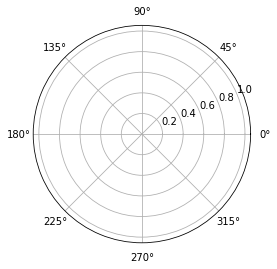

In [22]:
index = 1
rads = np.linspace(theta_lows[index], theta_ups[index], 100)
for rad in rads:
    plt.polar(2*pi*rad, 1, 'r')

In [17]:
np.array(result[1]) - np.array(result[2])

array([-0.04412307, -0.01729604, -0.01699872, -0.01729604, -0.01606014,
       -0.01626313, -0.0179952 , -0.02006227, -0.01648554, -0.01587457,
       -0.01515773, -0.00884498, -0.00235508, -0.00090329, -0.0003145 ])

In [18]:
result[3]

[True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True]